## Import necessary modules, set up environment

In [1]:

from matplotlib import pyplot as plt
from gymnasium import spaces
%matplotlib inline
# import gymnasium as gym
# from gym.envs.registration import registry, register
from minigrid.wrappers import DictObservationSpaceWrapper # so that text mission string is actually a numerical dict

# env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode = "rgb_array")
# env = DictObservationSpaceWrapper(env) # ONLY DO THIS FOR PPO TRAINING
# env.metadata['render_modes'] = ["rgb_array"]
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch import nn
# import gym
import torch
import minigrid
from minigrid.wrappers import ImgObsWrapper, RGBImgObsWrapper, RGBImgPartialObsWrapper, DictObservationSpaceWrapper, ViewSizeWrapper
from stable_baselines3 import PPO
import gymnasium



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
env = gymnasium.make("MiniGrid-LockedRoom-v0")
print(env.observation_space)
env = RGBImgPartialObsWrapper(env)
print(env.observation_space)

Dict('direction': Discrete(4), 'image': Box(0, 255, (7, 7, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x164877ec0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))
Dict('direction': Discrete(4), 'image': Box(0, 255, (56, 56, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x164877ec0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))


## Set up the wrappers for the environment

`MissionEncodingWrapper` adds one for every discrete space in the one-hot encoding of the mission, allowing 0 to be encoded as well.

`ImageFeaturesExtractor` extracts relevant features if the observation is just an image, used with `ImgObsWrapper`

`MinigridFeaturesExtractor` extracts relevant features from the entire observation, used with `MissionEncodingWrapper` and `DictObservationSpaceWrapper`

In [2]:

from gymnasium import ObservationWrapper
import numpy as np
# a custom wrapper to make the mission vector work with one hot encoding
class MissionEncodingWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = env.observation_space
        self.observation_space['mission'] = spaces.MultiDiscrete(np.array([n+1 for n in env.observation_space['mission'].nvec]))
    def observation(self, obs):
        return obs
    
    

In [4]:
class ImageFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: gymnasium.Space, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

In [5]:
class MinigridFeaturesExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Dict, features_dim: int = 512, normalized_image: bool = False) -> None:
        super().__init__(observation_space, features_dim)
        direction = observation_space['direction']
        image = observation_space['image']
        mission_string = observation_space['mission']
        n_input_channels = image.shape[0] # should be 3, for RGB
        
        
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU(),
            nn.Flatten(),
        )
        
        direction_output_dim = 8
        self.direction_net = nn.Sequential(nn.Linear(direction.n, direction_output_dim), nn.ReLU()) 
        
        
        ## add text extractor
        self.transformer = nn.Transformer(d_model=len(mission_string), nhead=2, num_encoder_layers=2, num_decoder_layers=2) # squared because of one hot encoding
        

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(torch.as_tensor(observation_space['image'].sample()[None]).float()).shape[1] ## 1024 for this example
            
        self.sentence_transformer_dim = len(mission_string) # is one-hot best here? or should we condense it to 50D vector?
            
        linear_input_dim = n_flatten + self.sentence_transformer_dim + direction_output_dim
        self.linear = nn.Sequential(nn.Linear(linear_input_dim, features_dim), nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        image_features = self.cnn(observations['image']) # .transpose((2, 0, 1)
        direction_features = self.direction_net(observations['direction'])
        if direction_features.shape[1] == 1:
            direction_features = direction_features.squeeze(1)
            
       
        one_hot_mission = observations['mission'].squeeze(0)
       
        mission_string_encoding = torch.empty((observations['mission'].shape[0], self.sentence_transformer_dim))
        
        # turn back into labels instead of one hot encoding
        for i in range(0, self.sentence_transformer_dim**2, self.sentence_transformer_dim):

            if len(one_hot_mission.size()) == 1:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = (torch.argmax(one_hot_mission[i:i+self.sentence_transformer_dim], dim = 0))
            else:
                mission_string_encoding[:, i//self.sentence_transformer_dim] = torch.argmax(one_hot_mission[:, i:i+self.sentence_transformer_dim], dim = 1)
       
        src = trg = torch.as_tensor(mission_string_encoding).unsqueeze(0).float()
        
        sentence_features = self.transformer(src, trg).squeeze(0) # to match dimensions

        
        try:
            observations = torch.cat([image_features, sentence_features, direction_features], dim = 1)
        except Exception as err:
            print(err)
            print("image features dim", image_features.shape)
            print("sentence features dim", sentence_features.shape)
            print("direction features dim", direction_features.shape)
        return self.linear(observations)

### Train the model and save it. -- also try `FlatObsWrapper`

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN

Dict('direction': Discrete(4), 'image': Box(0, 255, (152, 152, 3), uint8), 'mission': MissionSpace(<function LockedRoomEnv._gen_mission at 0x164877ec0>, [['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow'], ['blue', 'green', 'grey', 'purple', 'red', 'yellow']]))
(608, 608, 3)


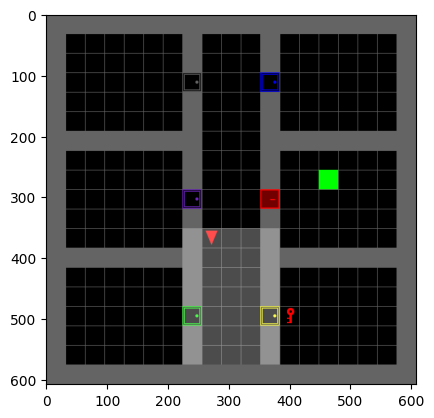

In [6]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
# env = DictObservationSpaceWrapper(env)
# env = MissionEncodingWrapper(env)
env = RGBImgObsWrapper(env)

print(env.observation_space)
env.reset()
r = env.render()
print(r.shape)
plt.imshow(r)

In [3]:
class Actions:
    LEFT = 0
    RIGHT = 1
    FORWARD = 2
    PICKUP = 3
    DROP = 4
    TOGGLE = 5
    DONE = 6

DIRECTION:
Up: 3
Left: 2
Down: 1
Right: 0

### Record Video of the trained policy

## How to render image

-- good for passing into GPT4 VLM

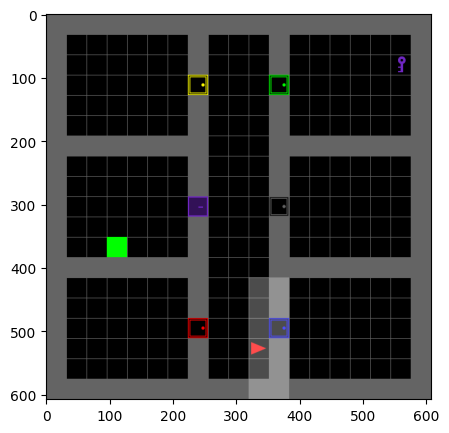

In [8]:
env.reset()
render = env.render()
fig, ax = plt.subplots(ncols=1, figsize=(12, 5))
ax.imshow(render) # , cmap=plt.get_cmap('gray')
plt.show()

## Custom Reward Function

In [3]:
from openai import OpenAI
from api.settings import Settings

openai_client = OpenAI(api_key=Settings().openai_key)

def vision(prompt_text: str, img_base64: str):
    """Run a GPT-4 vision model on the prompt text and image.

    ```
    from PIL import Image
    im = Image.fromarray(r)
    vision("what do you see?", image_to_base64(im))
    ```
    """
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{img_base64}",
                        "detail": "low"
                    },
                },
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.2,
        max_tokens=600,
    )
    return response


# def complete(prompt_text: str):
#     """Run a GPT-4 model on the prompt text."""
#     gpt_model = "gpt-4-turbo"

#     messages = [
#         {
#             "role": "user",
#             "content": [
#                 {"type": "text", "text": prompt_text},
#             ],
#         }
#     ]

#     response = openai_client.chat.completions.create(
#         model=gpt_model,
#         messages=messages,
#         temperature=0.2,
#         max_tokens=300,
#     )
#     return response


def complete(prompt_text: str):
    """Run a GPT-4 model on the prompt text."""
    gpt_model = "gpt-4-turbo"

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt_text},
            ],
        }
    ]

    response = openai_client.chat.completions.create(
        model=gpt_model,
        messages=messages,
        temperature=0.9,
        max_tokens=4096,
    )
    return response



## Custom Reward

In [15]:
image_env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")

ob, info = image_env.reset()
render = image_env.render()
ob['mission']

'get the green key from the blue room, unlock the green door and go to the goal'

'get the purple key from the grey room, unlock the purple door and go to the goal'

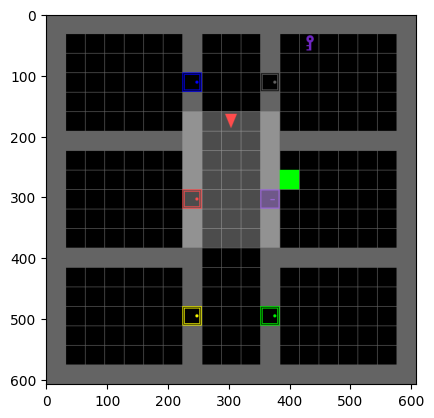

In [16]:
ob, info = image_env.reset()
render = image_env.render()
plt.imshow(render)
ob['mission']

In [17]:
prompt1 = '''You are an assistant aiding with subgoal generataion for reinforcement learning problems. Specifically, you will
be given an example environment picture and a textual goal description, and you are to output language subgoals that the agent
should achieve in order to efficiently and successfully achieve the main goal.

The goal description is:

“get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

where you can use {lockedroom_color}, {keyroom_color}, and {door_color} as variables in the subgoals and the goal is a light green square.
The variables can be the values “red”, “green”, “blue”, “purple”, “yellow” or “grey”.

These subgoals should be with respect to the image itself: they should specify specific observations that
show that the agent is on track. They should also be singular; they should output exactly one subtask instead of a group of multiple steps.
Output a list of ONLY these text subgoals in the following format (without any introduction text):

- [subgoal 1]
- [subgoal 2]
- ...

where [subgoal i] is replaced by the ith subgoal. subgoals Do not create directional subgoals but rather strategic
subgoals that do not hard code the direction but instead tell the agent which states are more beneficial. The subgoals should be able to be completed
by the agent moving, picking up a key, or using a key.

You should enough subgoals to be descriptive but not redundant. Use the included example image to be specific.

Remember that the included image is an example of the environment but the door, key, and goal locations may differ so use it for context but do not
hardcode the goals with respect to this specific image.
'''

prompt2_part1 = '''
You are an assistant tasked with turning language subgoals into machine readable code. You will be given text subgoals, and you must translate
these subgoals into code that takes in an observation of the format

{'direction': Discrete(4), 'image': np.ndarray, 'mission': str}

'direction' is a number with the corresponding direction:
    3: Up
    2: Left
    1: Down
    0: Right

'image' is of shape (width x height x 3), and the final dimension corresponds to a 3D tuple of (OBJECT_IDX, COLOR_IDX, STATE). Here, 

OBJECT_IDX is a number with the corresponding object type: 
    0: "unseen"
    1: "empty"
    2: "wall"
    3: "floor"
    4: "door"
    5: "key"
    
COLOR_IDX is a number with the corresponding color:
    0: "red"
    1: "green"
    2: "blue"
    3: "purple"
    4: "yellow"
    5: "grey"

STATE is a number with the corresponding state if the object is a door: 
    0: "open"
    1: "closed"
    2: "locked"

The agent is centered at the bottom of the image.

'mission' is of the form “get the {lockedroom_color} key from the {keyroom_color} room, unlock the {door_color} door and go to the goal”

The text subgoals will include these variables {lockedroom_color}, {keyroom_color}, and {door_color}, which are integers corresponding to the above encoding for COLOR_IDX.

As part of your reward function, you can use these three variables {lockedroom_color}, {keyroom_color}, and {door_color}
to determine your specific reward function for the subgoal. You can also use the action which comes as an integer 0 through 6, labeled as follows:

0: turn left, 1: turn right, 2: move forward, 3: pick up an object, 4: DON'T USE, 5: toggle/activate an object, 6: DON'T USE

The reward function must have the signature: reward_{i}(observation, action, lockedroom_color, keyroom_color, door_color) where i is '''

prompt2_part2 = '''
. 
Output the subgoal as a  python functions that takes in the above parameters and returns the reward that prioritizes the specific subgoal. The only external library you can use is numpy.
This reward function should be dense; it should make the agent want to move closer to the specific subgoal. For example, you can use a distance function to achieve this for certain subgoals. You can also
add reward components to ensure the prerequisites for the current subgoal are achieved if you think that would help.
Have the maximum reward of the function be 1 (where the goal is obtained) and the minimum be 0. DO NOT use float('inf') or float('-inf') in your function.
The code should be the only thing you output, all in one python function without sub functions.'''

In [18]:
from PIL import Image
from api.image import image_to_base64

im = Image.fromarray(render)
completion1 = vision(prompt1, image_to_base64(im))

In [19]:
print(completion1.choices[0].message.content)

- Locate the {keyroom_color} room.
- Navigate to the {keyroom_color} room.
- Acquire the {lockedroom_color} key located in the {keyroom_color} room.
- Identify the {door_color} door.
- Move to the {door_color} door.
- Use the {lockedroom_color} key to unlock the {door_color} door.
- Proceed through the unlocked {door_color} door.
- Reach the goal area marked by the light green square.


Limitations:: vision -- need better model!

In [20]:
im = Image.fromarray(render)
iterations = 3
subgoal_set = []
chars = ['A', 'B', 'C']
for j in range(iterations):
    completions = []
    for i, sg in enumerate(completion1.choices[0].message.content.splitlines()):
        completions.append(complete(prompt2_part1 + str(i) + chars[j] + prompt2_part2 + '\nThe textual subgoal is as follows: ' + sg))
        
    completion_funcs = [c.choices[0].message.content for c in completions]
    completion_funcs_execute = ['\n'.join(c.splitlines()[1:-1]) for c in completion_funcs]
    subgoal_set.append(completion_funcs_execute)
    for c in completion_funcs_execute:
        exec(c)

In [13]:
def mission_to_string(mission_encoding):
    indices = [idx - 1 for idx in mission_encoding] # remove offset
    translation = {v: k for k, v in DictObservationSpaceWrapper.get_minigrid_words().items()}
    translation[-1] = ''
    return ' '.join([translation[idx] for idx in indices])
    

In [38]:
from gymnasium import RewardWrapper
RENDERS = []
class CustomRewardWrapper(RewardWrapper):
    def __init__(self, env, reward_func):
        super().__init__(env)
        self.generate_reward_func = reward_func # (obs, action) -> reard
        self.counts = {} # ((x, y), action) => count
        
    def step(self, action):
        
        #params
        bonus_factor = 0.01 # the exploration bonus
        intrinsic_factor = 0.9 # how much the intrinsic reward should be weighted
        progress_bonus = 1.5 # the bonus for reaching farther and farther goals
        
        observation, _, terminated, truncated, info = self.env.step(action)
        reward, goal_number =  self.reward_func(observation, action)

        # save render for debugging
        if goal_number >= 3:
            RENDERS.append(self.env.render())
        
        reward *= (progress_bonus ** goal_number) * intrinsic_factor # to incentivize further goals
        
        pos = tuple(self.agent_pos)
        state_and_action = (pos, action.item())

        # Get the count for this key
        count = self.counts[state_and_action] if state_and_action in self.counts else 0

        # Update the count for this key
        self.counts[state_and_action] = count + 1
        
        bonus = 1 / math.sqrt(self.counts[state_and_action])
        #reward += bonus_factor + bonus

        # Get the position in front of the agent
        fwd_pos = self.front_pos
        fwd_cell = self.grid.get(*fwd_pos)
        if action == self.actions.forward and fwd_cell is not None and fwd_cell.type == "goal":
            print("REACHED GOAL, EXTRINSIC REWARD: ", self._reward())
            reward += self._reward()
            
            
        return observation, reward, terminated, truncated, info
    
    
    def reset(self, **kwargs):
        self.reward_func = self.generate_reward_func()
        obs, info = self.env.reset(**kwargs)
        return obs, info

In [24]:
print(len(subgoal_set[0]))

8


##### MANUAL Test for subgoal sucess

In [159]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")

x = env.reset()



[[4 1]
 [6 3]]
(6, 3)
[[False False False False False False False]
 [False False False False False False False]
 [ True False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]
 [False False False False False False False]]
(array([2]), array([0]))


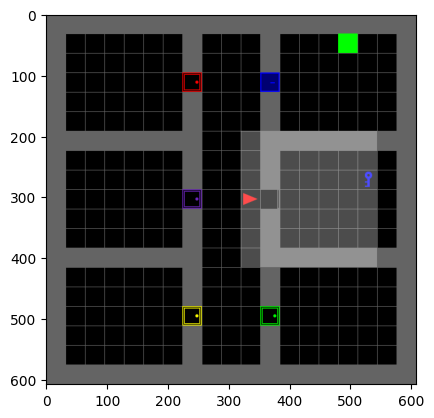

In [193]:
obs, *_ = env.step(np.array([Actions.TOGGLE]))
r = env.render()
plt.imshow(r)
image = obs['image']
keyroom_color = 2 # blue
key = 5
key_positions = np.nonzero((obs['image'][:, :, 0] == key) & (obs['image'][:, :, 1] == keyroom_color))
agent_position = (image.shape[0] - 1, image.shape[1] // 2)ss

if len(key_positions) > 0:
    print((obs['image'][:, :, 0] == key) & (obs['image'][:, :, 1] == keyroom_color))
    print(key_positions)


In [140]:

key_positions = np.argwhere((obs['image'][:, :, 0] == 5) & (obs['image'][:, :, 1] == keyroom_color))
print(key_positions)

[]


0.0
0.2857142857142857
0.01


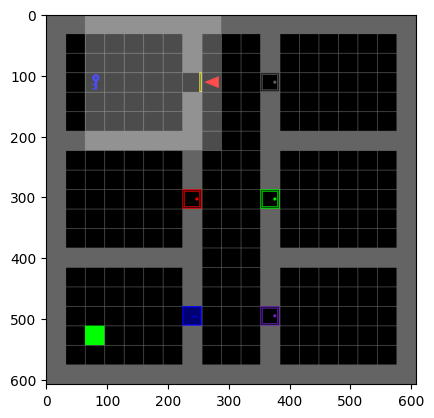

In [209]:
# env.reset()
action = np.array([Actions.TOGGLE])
obs, _, _, _, _ = env.step(action)
r = env.render()
plt.imshow(r)
COLOR_TO_IDX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4, "grey": 5}

mission = obs['mission']#mission_to_string(obs['mission'])
# preprocess -- ideally this would be done with LLM if we had more compute
lockedroom_color = COLOR_TO_IDX[mission.split(' ')[2]]
keyroom_color = COLOR_TO_IDX[mission.split(' ')[6]]
door_color = COLOR_TO_IDX[mission.split(' ')[10]]

print(reward_1A(obs, action, lockedroom_color, keyroom_color, door_color))
print(reward_2A(obs, action, lockedroom_color, keyroom_color, door_color))
print(reward_3A(obs, action, lockedroom_color, keyroom_color, door_color))

In [108]:
print(subgoal_set[0][1])
print(subgoal_set[1][1])
print(subgoal_set[2][1])

import numpy as np

def reward_1A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Extract variables from observation
    direction = observation['direction']
    image = observation['image']
    mission = observation['mission']
    
    # Constants
    KEY_OBJECT_IDX = 5
    KEY_PICKUP_ACTION = 3
    
    # Setup rewards
    max_reward = 1.0
    min_reward = 0.0
    distance_penalty_weight = 0.01
    wrong_action_penalty = -0.1

    # Determine the position of the agent (assumed at the bottom center of the image)
    agent_position = (image.shape[0] - 1, image.shape[1] // 2)
    
    # Identify all key positions in the keyroom_color room
    key_positions = np.argwhere((image[:, :, 0] == KEY_OBJECT_IDX) & (image[:, :, 1] == keyroom_color))
    
    # If there are no keys in the keyroom_color, return minimum reward
    if key_positions.size == 0:
        return min_reward
    
    # Calculate the Manhattan distance to the closest key of the correct color in the 

## TRAINING

In [409]:
print(subgoal_set[0][2])

import numpy as np

def reward_2A(observation, action, lockedroom_color, keyroom_color, door_color):
    image = observation['image']
    width, height, _ = image.shape
    agent_y = height - 1  # Agent is at the bottom row of the image
    
    # Finding the {door_color} door position
    door_positions = []
    for x in range(width):
        for y in range(height):
            # Check if it is a door with the required color and is either closed or locked
            if image[x, y, 0] == 4 and image[x, y, 1] == door_color and image[x, y, 2] in (1, 2):
                door_positions.append((x, y))
    
    # If no door is found, minimum reward
    if not door_positions:
        return 0.0
    
    # Compute the minimum Manhattan distance from the agent position to any {door_color} door
    min_distance = min(abs(x - (width // 2)) + abs(y - agent_y) for x, y in door_positions)
  
    # Normalize the distance to get a reward between 0 and 1, where 1 is at the door
    max_possible_distan

In [422]:
len(subgoal_set)

3

In [39]:

import math
EPSILON = 0.1
def generate_total_reward():
    goal_number = 0
      
    reward_funcs = [
        (reward_0A, reward_0B, reward_0C),
        (reward_1A, reward_1B, reward_1C),
        (reward_2A, reward_2B, reward_2C),
        (reward_3A, reward_3B, reward_3C),
        (reward_4A, reward_4B, reward_4C),
        (reward_5A, reward_5B, reward_5C),
        (reward_6A, reward_6B, reward_6C),
        (reward_7A, reward_7B, reward_7C)
    ]
    def total_reward(obs, action):
        nonlocal goal_number
        
        # print(obs)
        gamma = 0.0005 # probability to skip to next subgoal
        
        COLOR_TO_IDX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4, "grey": 5}
        
        # preprocess -- ideally this would be done with LLM if we had more compute
        lockedroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[2]]
        keyroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[6]]
        door_color = COLOR_TO_IDX[obs['mission'].split(' ')[10]]
        
        
        rewards = []
        for sg_num, sg in enumerate(reward_funcs):
            reward = 0
            for i, r in enumerate(sg):
                if 'inf' in subgoal_set[i][sg_num]:
                    continue
                try:
                    reward = max(r(obs, action, lockedroom_color, keyroom_color, door_color), reward)
                except:
                    pass
            rewards.append(reward)
            
        
        # goals are often related, so weight future goals (on decay)
        decay = 0.4 # lambda
        reward = sum((rewards[i] * (decay**i)) for i in range(len(rewards[goal_number:])))
            
        # or np.random.rand() < gamma

        if (rewards[goal_number] > 1-EPSILON) and goal_number < len(reward_funcs) - 1:
            
            print("switching functions from " + str(goal_number) + " to " + str(goal_number + 1))
            goal_number += 1
            
        
            
        
        return reward, goal_number
    
    return total_reward

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")

# env = ViewSizeWrapper(env, agent_view_size=7) # so the cnn can work with kernel size 8
env = CustomRewardWrapper(env, generate_total_reward)
env = RGBImgPartialObsWrapper(env) # reward is calculated using regular obs, then plugged into model with img obs
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)



In [414]:
print(subgoal_set[0][4])

import numpy as np

def reward_4A(observation, action, lockedroom_color, keyroom_color, door_color):
    image = observation['image']
    direction = observation['direction']
    
    # Constants for image interpretation
    OBJECT_IDX = 4  # Index for 'door'
    DOOR_STATE_OPEN = 0
    
    # Locate doors that match the door_color and are open
    door_positions = np.where((image[:, :, 0] == OBJECT_IDX) & (image[:, :, 1] == door_color) & (image[:, :, 2] == DOOR_STATE_OPEN))
    
    if len(door_positions[0]) > 0:
        # Calculate distance to the nearest correct door
        agent_position = (image.shape[0] - 1, image.shape[1] // 2)  # Agent is centered at the bottom of the image
        distances = np.sqrt((door_positions[0] - agent_position[0]) ** 2 + (door_positions[1] - agent_position[1]) ** 2)
        min_distance = np.min(distances)

        # Normalize distance to be a value between 0 and 1, where 0 is the farthest and 1 is at the door
        max_possible_distance = np.sqrt(

In [40]:
model = PPO("MultiInputPolicy", env, verbose=1, ent_coef=0.3)
model.learn(2e5)
model.save("minigrid_models/minigrid_custom/15-skipping-steps")

env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-15', episode_trigger=lambda e: e % 1 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 30000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    steps += 1
env.close_video_recorder()
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 5.08     |
| time/              |          |
|    fps             | 483      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 190          |
|    ep_rew_mean          | 5.31         |
| time/                   |              |
|    fps                  | 226          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0087223435 |
|    clip_fraction        | 0.0421       |
|    clip

In [12]:

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")

env = RGBImgPartialObsWrapper(env) # reward is calculated using regular obs, then plugged into model with img obs
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)
model = PPO.load("minigrid_models/minigrid_custom/15-skipping-steps")

env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-15', episode_trigger=lambda e: e % 1 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 30000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    steps += 1
env.close_video_recorder()
env.close()

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-15/rl-video-episode-0.mp4


## REFLECTION AND FEEDBACK

In [387]:
prompt3_reflection = '''
I trained a PPO model on a minigrid environment with reward generated using GPT4 with the following prompt:
''' + prompt2_part1 + prompt2_part2 + ''' The environment has colored doors the agent must pass through and unlock
to reach the goal. For 6 subgoals, 3 reward functions were outputted by GPT4 and the maximum reward was
taken for each subgoal. The code to do this is as follows:

reward = 0
for r in reward_funcs[goal_number]:
    try:
        reward = max(reward, r(obs, action, lockedroom_color, keyroom_color, door_color))
    except:
        pass
if reward > 1-EPSILON:
    goal_number += 1

where reward_funcs is a list of reward functions:''' + str(subgoal_set) + '''

The policy gave this final feedback:

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 190         |
|    ep_rew_mean          | 44.5        |
| time/                   |             |
|    fps                  | 144         |
|    iterations           | 123         |
|    time_elapsed         | 1742        |
|    total_timesteps      | 251904      |
| train/                  |             |
|    approx_kl            | 0.020666333 |
|    clip_fraction        | 0.231       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | -0.439      |
|    learning_rate        | 0.0003      |
|    loss                 | -0.321      |
|    n_updates            | 1220        |
|    policy_gradient_loss | -0.0402     |
|    value_loss           | 0.869       |
-----------------------------------------
and it only made it to subgoal 2.

Your job is to edit these reward functions based on this feedback and output new rewards in the same format as the inputted list. 
These new reward functions should help solve the task better than previously. You can rewrite them entirely, or provide
edits to them, taking into account the three 'drafts' for each subgoal. All the functions must keep their same signatures and in the same list format as the input.
Do not use float('inf') or float('-inf').

Make sure to output six (6) new reward functions, one for each of the following subgoals:

- Locate the {keyroom_color} room.
- Find and pick up the {lockedroom_color} key in the {keyroom_color} room.
- Navigate to the {door_color} door.
- Use the {lockedroom_color} key to unlock the {door_color} door.
- Proceed through the unlocked {door_color} door.
- Reach the goal area marked by the light green square.
'''

In [388]:
revised_subgoals = complete(prompt3_reflection)

-0.16666666666666674


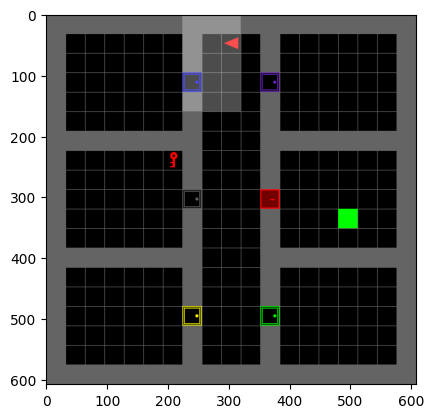

In [386]:
env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")
env.reset()
r = env.render()
plt.imshow(r)
obs, *_ = env.step(np.array([Actions.RIGHT]))

r = env.render()
plt.imshow(r)
mission = obs['mission']
lockedroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[2]]
keyroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[6]]
door_color = COLOR_TO_IDX[obs['mission'].split(' ')[10]]

print(reward_0(obs, np.array([Actions.RIGHT]), lockedroom_color, keyroom_color, door_color))

In [389]:
print(revised_subgoals.choices[0].message.content)

```python
[
    [
        """import numpy as np
        def reward_0A(observation, action, lockedroom_color, keyroom_color, door_color):
            image = observation['image']
            width, height, _ = image.shape
            agent_x = width // 2
            agent_y = height - 1
            key_room_color = keyroom_color
            min_distance = np.inf
            for y in range(height):
                for x in range(width):
                    obj_idx, color_idx, _ = image[y, x]
                    if obj_idx == 3 and color_idx == key_room_color:
                        distance = np.sqrt((agent_x - x) ** 2 + (agent_y - y) ** 2)
                        if distance < min_distance:
                            min_distance = distance
            if min_distance == 0:
                reward = 1
            else:
                reward = 1 / (1 + min_distance)
            return reward"""
    ],
    [
        """import numpy as np
        def reward_1A(observation, action, locked

In [376]:
c = '\n'.join(revised_subgoals.choices[0].message.content.splitlines()[1:-1])

exec(c)

In [344]:
def reward_0A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward function to locate the {keyroom_color} room
    image = observation['image']
    height, width, _ = image.shape
    agent_x = width // 2
    agent_y = height - 1
    reward = 0
    key_room_floor_color = keyroom_color
    min_distance = float('inf')
    for y in range(height):
        for x in range(width):
            obj_idx, color_idx, _ = image[y, x]
            if obj_idx == 3 and color_idx == key_room_floor_color:
                distance = np.sqrt((agent_x - x) ** 2 + (agent_y - y) ** 2)
                if distance < min_distance:
                    min_distance = distance
    # Improved normalization technique for distance reward
    max_possible_distance = np.sqrt(width ** 2 + height ** 2)
    if min_distance == 0:
        reward = 1  # Max reward if already at the keyroom floor
    else:
        reward = 1 - (min_distance / max_possible_distance)
    return reward

def reward_1A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward for finding and picking up the {lockedroom_color} key in the {keyroom_color} room
    image = observation['image']
    width, height, _ = image.shape
    agent_x, agent_y = width // 2, height - 1

    reward = 0
    key_found = False
    min_distance_to_key = float('inf')
    
    for x in range(width):
        for y in range(height):
            object_idx, color_idx, _ = image[x, y]
            # Consider only keys within the {keyroom_color} room
            if object_idx == 5 and color_idx == lockedroom_color:
                if image[x, y, 0] == 3 and image[x, y, 1] == keyroom_color:
                    distance = np.sqrt((agent_x - x) ** 2 + (agent_y - y) ** 2)
                    if distance < min_distance_to_key:
                        min_distance_to_key = distance

                    if distance == 0 and action == 3:
                        key_found = True
    
    max_distance = np.sqrt(width ** 2 + height ** 2)
    if not key_found:
        reward = 1 - (min_distance_to_key / max_distance)
    else:
        reward = 1
    return reward

def reward_2A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward to navigate to the {door_color} door
    image = observation['image']
    agent_position = (image.shape[1] // 2, image.shape[0] - 1)
    target_door_found = False
    min_distance = float('inf')

    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if image[y, x, 0] == 4 and image[y, x, 1] == door_color and image[y, x, 2] in [1, 2]:
                distance = np.sqrt((agent_position[0] - x) ** 2 + (agent_position[1] - y) ** 2)
                if distance < min_distance:
                    min_distance = distance
                    target_door_found = True

    if target_door_found:
        max_possible_distance = np.sqrt(image.shape[0]**2 + image.shape[1]**2)
        reward = 1 - (min_distance / max_possible_distance)
    else:
        reward = 0
    return reward

def reward_3A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward for using the {lockedroom_color} key to unlock the {door_color} door
    image = observation['image']
    direction = observation['direction']
    reward = 0.0
    agent_position = (image.shape[1] // 2, image.shape[0] - 1)
    door_positions = []
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            object_idx, color_idx, state_idx = image[y, x]
            if object_idx == 4 and color_idx == door_color and state_idx == 2:
                door_positions.append((x, y))

    min_distance_to_door = float('inf')
    for door_pos in door_positions:
        distance = np.sqrt((door_pos[0] - agent_position[0]) ** 2 + (door_pos[1] - agent_position[1]) ** 2)
        if distance < min_distance_to_door:
            min_distance_to_door = distance

    normalized_distance = min_distance_to_door / np.sqrt(image.shape[0] ** 2 + image.shape[1] ** 2)
    proximity_reward = 1.0 - normalized_distance

    if action == 5:
        potential_positions = [
            (agent_position[0], agent_position[1] - 1),
            (agent_position[0] - 1, agent_position[1]),
            (agent_position[0], agent_position[1] + 1),
            (agent_position[0] + 1, agent_position[1])
        ]
        interaction_position = potential_positions[direction % 4]
        if 0 <= interaction_position[1] < image.shape[0] and 0 <= interaction_position[0] < image.shape[1]:
            inter_obj, inter_color, inter_state = image[interaction_position[1], interaction_position[0]]
            if inter_obj == 4 and inter_color == door_color and inter_state == 2:
                reward = 1
    return max(reward, proximity_reward)

def reward_4A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward for proceeding through the {door_color} door after it has been unlocked
    image = observation['image']
    agent_position = (image.shape[0] - 1, image.shape[1] // 2)
    door_positions = np.argwhere((image[:, :, 0] == 4) & (image[:, :, 1] == door_color) & (image[:, :, 2] == 0))
    
    if len(door_positions) == 0:
        return 0

    distances = np.sqrt((door_positions[:, 0] - agent_position[0]) ** 2 + (door_positions[:, 1] - agent_position[1]) ** 2)
    min_distance = np.min(distances)
    max_possible_distance = np.sqrt((image.shape[0] - 1) ** 2 + (image.shape[1] // 2) ** 2)
    reward = 1 - (min_distance / max_possible_distance)

    if action == 2:
        direction = observation['direction']
        movement_offsets = {0: (0, 1), 1: (0, -1), 2: (-1, 0), 3: (1, 0)}
        if direction in movement_offsets:
            next_step = (agent_position[0] + movement_offsets[direction][0], agent_position[1] + movement_offsets[direction][1])
            if 0 <= next_step[0] < image.shape[0] and 0 <= next_step[1] < image.shape[1]:
                next_step_distances = np.sqrt((door_positions[:, 0] - next_step[0]) ** 2 + (door_positions[:, 1] - next_step[1]) ** 2)
                if np.min(next_step_distances) < min_distance:
                    reward += 0.1
    return min(reward, 1)

def reward_5A(observation, action, lockedroom_color, keyroom_color, door_color):
    # Improved reward for reaching the goal area marked by the light green square
    image = observation['image']
    goal_positions = np.argwhere((image[:, :, 0] == 3) & (image[:, :, 1] == 1))
    agent_position = (image.shape[0] - 1, image.shape[1] // 2)
    
    if goal_positions.size == 0:
        return 0

    distances = np.sqrt((goal_positions[:, 0] - agent_position[0]) ** 2 + (goal_positions[:, 1] - agent_position[1]) ** 2)
    min_distance = np.min(distances)
    max_possible_distance = np.sqrt(agent_position[0]**2 + (image.shape[1]//2)**2)
    reward = 1 - (min_distance / max_possible_distance)
    return reward

In [392]:

EPSILON = 0.1
def generate_total_reward_reflection():
    goal_number = 0
      
    reward_funcs = [reward_0, reward_1, reward_2, reward_3, reward_4, reward_5]
    def total_reward(obs, action):
        nonlocal goal_number
        
        gamma = 0.005 # probability to skip to next subgoal
        
        # print(obs)
        
        COLOR_TO_IDX = {"red": 0, "green": 1, "blue": 2, "purple": 3, "yellow": 4, "grey": 5}
        
        # preprocess -- ideally this would be done with LLM if we had more compute
        lockedroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[2]]
        keyroom_color = COLOR_TO_IDX[obs['mission'].split(' ')[6]]
        door_color = COLOR_TO_IDX[obs['mission'].split(' ')[10]]
        
        reward = 0
       
        # if bug, try previous reward
        try:
            reward = reward_funcs[goal_number](obs, action, lockedroom_color, keyroom_color, door_color)
        except:
            reward = 0

        if (reward > 1-EPSILON or np.random.rand() < gamma) and goal_number < len(reward_funcs) - 1:
            
            print("switching functions from " + str(goal_number) + " to " + str(goal_number + 1))
            goal_number += 1
            
        
            
        
        return reward, goal_number
    
    return total_reward

env = gymnasium.make("MiniGrid-LockedRoom-v0", render_mode="rgb_array")

# env = ViewSizeWrapper(env, agent_view_size=7) # so the cnn can work with kernel size 8
env = CustomRewardWrapper(env, generate_total_reward_reflection)
env = RGBImgPartialObsWrapper(env) # reward is calculated using regular obs, then plugged into model with img obs
env = DictObservationSpaceWrapper(env)
env = MissionEncodingWrapper(env)



In [393]:
model = PPO("MultiInputPolicy", env, verbose=1, ent_coef=0.3)
model.learn(2.5e5)
model.save("minigrid_models/minigrid_custom/14-reward-with-feedback")

env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-14', episode_trigger=lambda e: e % 1 == 0)

obs, info = env.reset()
done = False
env.start_video_recorder()
steps = 0
while not done and steps <= 30000:
    action = model.predict(obs)[0]
    obs, reward, done, truncated, info = env.step(action)
    steps += 1
env.close_video_recorder()
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 0 to 1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 190      |
|    ep_rew_mean     | 97.2     |
| time/              |          |
|    fps             | 689      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 1 to 2
switching functions from 2 to 3
switching functions from 0 to 1
switching functions from 0 to 1
switching functions from 0 to 1
switching fun

/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:3

Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4
switching functions from 0 to 1
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:3

Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4
switching functions from 1 to 2
switching functions from 2 to 3
switching functions from 3 to 4
switching functions from 4 to 5


In [394]:

model.load("minigrid_models/minigrid_custom/14-reward-with-feedback")

env = gymnasium.wrappers.RecordVideo(env, 'videos/minigrid-language-14', episode_trigger=lambda e: e % 1 == 0)
for episode_num in range(4):
    obs, info = env.reset()

    episode_over = False
    while not episode_over:
        action = action = model.predict(obs)[0]
        obs, reward, terminated, truncated, info = env.step(action)

        episode_over = terminated or truncated
env.close_video_recorder()
env.close()


/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/co

switching functions from 0 to 1
switching functions from 1 to 2
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:3

Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-0.mp4
switching functions from 0 to 1
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:3

Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-1.mp4
switching functions from 0 to 1
switching functions from 1 to 2
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4



/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_frame to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_frame` for environment variables or `env.get_wrapper_attr('get_frame')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/.venv/lib/python3.12/site-packages/gymnasium/core.py:3

Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-2.mp4
switching functions from 0 to 1
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-4.mp4
Moviepy - Building video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/kmcclenn/Documents/Class notes/6.8200/final_project/language-reward-design/kai/videos/minigrid-language-14/rl-video-episode-3.mp4
